In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchdiffeq 
import zuko
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import *
import numpy as np
from zuko.utils import odeint
import pandas as pd

In [3]:
#device = torch.device("cuda:0")

In [4]:
#@title ⏳ Summary: please run this cell which contains the ```OTFlowMatching``` class
class OTFlowMatching:
  
  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min
    self.eps = 1e-5

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, noise: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x_0)
    x_0 = torch.randn_like(x_1) 
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t), noise)
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

In [5]:
from functools import partial
#@title ⏳ Summary: please run this cell which contains the ```CondVF``` class.
class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    return self.net(t, x, noise)
    
  def wrapper(self, t: torch.Tensor, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x), device=x.device)
      return partial(self, noise=noise)(t, x)

  def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    return odeint(partial(self.wrapper, noise=noise), x_0, 0., 1., self.parameters())

In [12]:
#@title ⏳ Summary: please run this cell which contains the ```Net``` class.
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
    super().__init__()

    ins = [(in_dim+1) + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
  
  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)
    
  def forward(self, t: torch.Tensor, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    print("t before encoding is", t)
    t = self.time_encoder(t)
    x = torch.cat((x, t, noise), dim=-1)
    print("t is ", t)

    for l in self.layers:
      x = l(x)
    return self.top(x)

In [13]:
import jax
jax.config.update('jax_platform_name', 'cpu')

from entot.models.utils import MixtureNormalSampler

source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

In [14]:
data = np.asarray(target)

In [15]:
"""def get_data(dataset: str, n_points: int) -> np.ndarray:
  if dataset == "moons":
    data, _ = make_moons(n_points, noise=0.15)
  elif dataset == "swiss":
    data, _ = make_swiss_roll(n_points, noise=0.25)
    data = data[:, [0, 2]] / 10.0
  return StandardScaler().fit_transform(data)


n_points = 10_000
DATASET = "swiss"
data = get_data(DATASET, n_points)

%matplotlib inline
plt.hist2d(data[:, 0], data[:, 1], bins=128)
plt.show()"""

'def get_data(dataset: str, n_points: int) -> np.ndarray:\n  if dataset == "moons":\n    data, _ = make_moons(n_points, noise=0.15)\n  elif dataset == "swiss":\n    data, _ = make_swiss_roll(n_points, noise=0.25)\n    data = data[:, [0, 2]] / 10.0\n  return StandardScaler().fit_transform(data)\n\n\nn_points = 10_000\nDATASET = "swiss"\ndata = get_data(DATASET, n_points)\n\n%matplotlib inline\nplt.hist2d(data[:, 0], data[:, 1], bins=128)\nplt.show()'

In [18]:
device="cpu"
batch_size = 8
dataset = torch.from_numpy(data).float()
dataset = dataset.to(device)
dataset = TensorDataset(dataset) 
dataloader = DataLoader(dataset, batch_size=batch_size)

In [19]:
def get_model(name: str):
    if name == "vp":
      raise NotImplementedError
      #return VPDiffusionFlowMatching()
    elif name == "ve":
      raise NotImplementedError
      #return VEDiffusionFlowMatching()
    if name == "ot":
      return OTFlowMatching()

MODEL = "ot"
model = get_model(MODEL)
net = Net(1, 1, [512]*5, 10).to(device)
v_t = CondVF(net)    

losses = [] 
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 1

    
for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader:
      x_1 = batch[0]
      #x_with_noise = torch.concat((x_1, torch.randn_like(x_1)), axis=1)
      # compute loss 
      loss = model.loss(v_t, torch.randn_like(x_1), x_1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses += [loss.detach()]

  0%|                                                             | 0/1 [00:00<?, ?it/s]

t before encoding is tensor([0.3010, 0.4260, 0.5510, 0.6760, 0.8010, 0.9260, 0.0510, 0.1760])
t is  tensor([[ 1.0000, -0.3151, -0.8014,  0.8201,  0.2846, -0.9995,  0.3452,  0.7819,
         -0.8380, -0.2539,  0.0000,  0.9491, -0.5981, -0.5722,  0.9586, -0.0319,
         -0.9385,  0.6234,  0.5457, -0.9672],
        [ 1.0000, -0.8939,  0.5981, -0.1753, -0.2846,  0.6842, -0.9385,  0.9937,
         -0.8380,  0.5044,  0.0000,  0.4483, -0.8014,  0.9845, -0.9586,  0.7293,
         -0.3452, -0.1121,  0.5457, -0.8634],
        [ 1.0000, -0.9491,  0.8014, -0.5722,  0.2846,  0.0319, -0.3452,  0.6234,
         -0.8380,  0.9672,  0.0000, -0.3151,  0.5981, -0.8201,  0.9586, -0.9995,
          0.9385, -0.7819,  0.5457, -0.2539],
        [ 1.0000, -0.4483, -0.5981,  0.9845, -0.2846, -0.7293,  0.9385, -0.1121,
         -0.8380,  0.8634,  0.0000, -0.8939,  0.8014,  0.1753, -0.9586,  0.6842,
          0.3452, -0.9937,  0.5457,  0.5044],
        [ 1.0000,  0.3151, -0.8014, -0.8201,  0.2846,  0.9995,  0.34

100%|█████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]

tensor([[ 1.0000,  0.3620, -0.7379, -0.8963,  0.0889,  0.9606,  0.6067, -0.5213,
         -0.9842, -0.1913,  0.0000,  0.9322,  0.6750, -0.4434, -0.9960, -0.2778,
          0.7949,  0.8534, -0.1770, -0.9815],
        [ 1.0000, -0.4031, -0.6750,  0.9473, -0.0889, -0.8757,  0.7949,  0.2348,
         -0.9842,  0.5588,  0.0000,  0.9151, -0.7379, -0.3202,  0.9960, -0.4829,
         -0.6067,  0.9721, -0.1770, -0.8293],
        [ 1.0000, -0.9322,  0.7379, -0.4434,  0.0889,  0.2778, -0.6067,  0.8534,
         -0.9842,  0.9815,  0.0000,  0.3620, -0.6750,  0.8963, -0.9960,  0.9606,
         -0.7949,  0.5213, -0.1770, -0.1913],
        [ 1.0000, -0.9151,  0.6750, -0.3202, -0.0889,  0.4829, -0.7949,  0.9721,
         -0.9842,  0.8293,  0.0000, -0.4031,  0.7379, -0.9473,  0.9960, -0.8757,
          0.6067, -0.2348, -0.1770,  0.5588],
        [ 1.0000, -0.3620, -0.7379,  0.8963,  0.0889, -0.9606,  0.6067,  0.5213,
         -0.9842,  0.1913,  0.0000, -0.9322,  0.6750,  0.4434, -0.9960,  0.2778,
      

In [115]:
def div_fn(x, t, noise, eps):
    with torch.enable_grad():
      x.requires_grad_(True)
      res = v_t(t[:,0], x, noise)
      print(res.shape)
      fn_eps = torch.sum(res * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    print(torch.sum(grad_fn_eps * eps).shape)
    return torch.sum(grad_fn_eps * eps)#, dim=tuple(range(1, len(x.shape))))

def eval_at_0(x, noise):
   with torch.no_grad():
      return torch.sum(torch.log(v_t(torch.zeros(x.shape)[:,0], x, noise)))

In [118]:
t= torch.tensor([0.5])
noise = torch.randn_like(x_const)
r_div = div_fn(x_const, t[:, None].expand(x_const.shape), noise, torch.randn_like(x_const))
r_zero = eval_at_0(x_const ,noise )

torch.Size([100, 1])
torch.Size([])


In [121]:
r_div

tensor(190.0720)

In [57]:
n_samples = 128
with torch.no_grad():
    x_0 = torch.randn(n_samples, 1, device=device)
    #x_with_noise = torch.concat((x_0, torch.randn_like(x_0)), axis=1)
    x_1_hat = v_t.decode(x_0, torch.randn_like(x_0))

In [58]:
x_1_hat.shape

torch.Size([128, 1])

<Axes: xlabel='source', ylabel='mapped'>

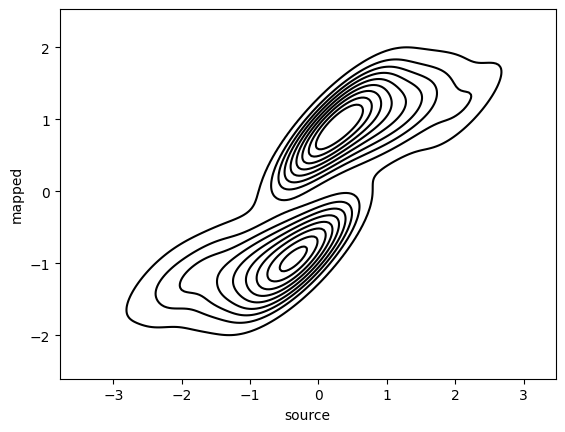

In [59]:
import seaborn as sns
joint_dist = np.concatenate((x_0, x_1_hat), axis=1)
jd = pd.DataFrame(data=joint_dist, columns=["source", "mapped"])
sns.kdeplot(
    data=jd,
    x="source",
    y="mapped",  # xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), # make T_xz 2d
    color="black",
    alpha=1.0,
    #fill=True,
    levels=10,
    #cmap="mako",
)

In [75]:
with torch.no_grad():
    x_02 = torch.ones((1,)) * -0.01#torch.randn(1,1)
    x_const = np.repeat(x_02, 100)[:, None]
    x_const_hat = v_t.decode(x_const, torch.randn_like(x_const))

<Axes: ylabel='Density'>

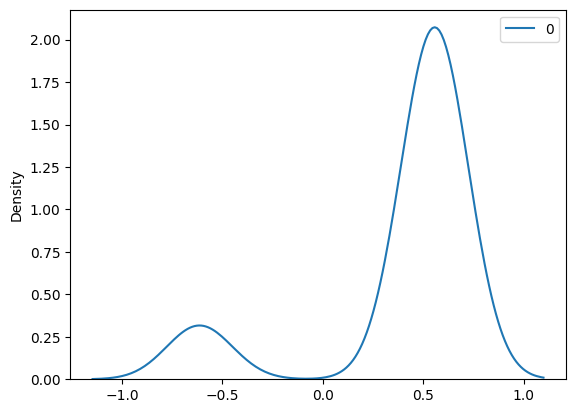

In [76]:
sns.kdeplot(x_const_hat)

In [29]:
import ott
import seaborn as sns
from entot.models.utils import _concatenate

geom = ott.geometry.pointcloud.PointCloud(np.asarray(x_0), np.asarray(x_1_hat), epsilon=0.1)
sinkhorn_output = ott.solvers.linear.sinkhorn.Sinkhorn()(
    ott.problems.linear.linear_problem.LinearProblem(geom)
)



In [30]:
pi_star_inds = jax.random.categorical(
        jax.random.PRNGKey(0), logits=np.log(sinkhorn_output.matrix.flatten()), shape=(len(x_0),)
    )
inds_source = pi_star_inds // len(x_1_hat)
inds_target = pi_star_inds % len(x_1_hat)
data = np.concatenate((x_0[np.asarray(inds_source)], x_1_hat[np.asarray(inds_target)]), axis=1)
gt = pd.DataFrame(data=data, columns=["source", "target"])


/tmp/ipykernel_66122/1058360828.py:2: RuntimeWarning: divide by zero encountered in log
  jax.random.PRNGKey(0), logits=np.log(sinkhorn_output.matrix.flatten()), shape=(len(x_0),)


<Axes: xlabel='source', ylabel='target'>

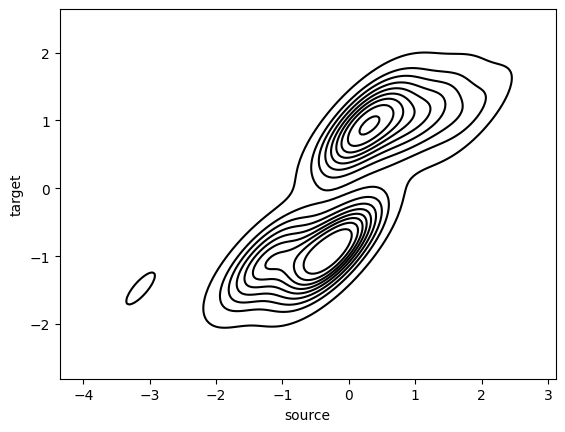

In [31]:
sns.kdeplot(
    data=gt,
    x="source",
    y="target",  # xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), # make T_xz 2d
    color="black",
    alpha=1.0,
    #fill=True,
    levels=10,
    #cmap="mako",
)

<Axes: xlabel='source', ylabel='mapped'>

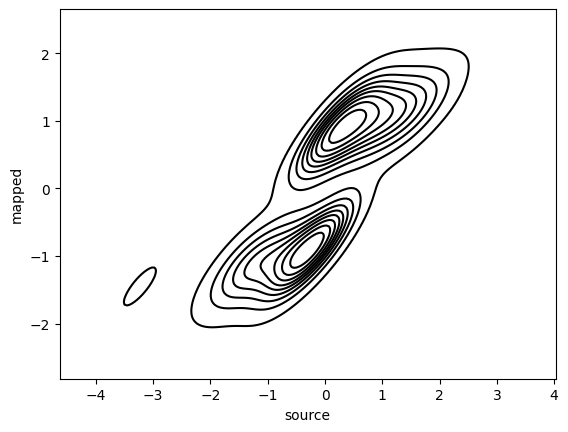

In [28]:
import seaborn as sns
joint_dist = np.concatenate((x_0, x_1_hat), axis=1)
jd = pd.DataFrame(data=joint_dist, columns=["source", "mapped"])
sns.kdeplot(
    data=jd,
    x="source",
    y="mapped",  # xlim=(-2.5, 2.5), ylim=(-2.5, 2.5), # make T_xz 2d
    color="black",
    alpha=1.0,
    #fill=True,
    levels=10,
    #cmap="mako",
)

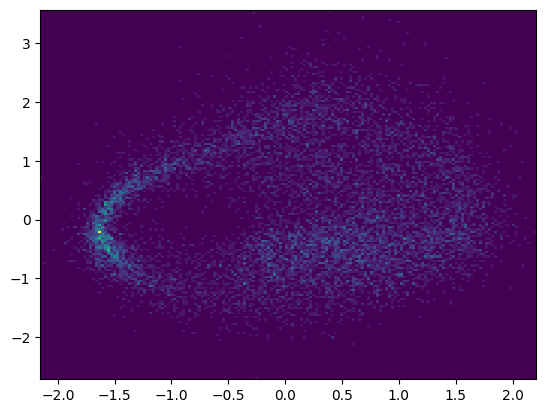

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
x_1_hat = x_1_hat.cpu().numpy()
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)
plt.show()